In [32]:
from IPython.display import HTML, display
display(HTML("<style>.container { width:95% !important; }</style>"))

**Instructions to import interval and cartopy**

In [33]:
# To use this cell you will need to pip install pyinterval and cartopy. 
# Uncomment below to do so. Note, pip install had issues for cartopy so 
#                we are using the alternative to installing the package

# pip install pyinterval
# conda install -c conda-forge cartopy

In [34]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from interval import interval, inf, imath   

# Functions for Modeling Orbits & Groundtracking & Tracking Equatorial Coverage 

In [35]:
# Eq. 25, https://en.wikipedia.org/wiki/Kepler_orbit#Properties_of_trajectory_equation
# Note eq. 24 implies a unique E for all t and 0 < e < 1.
t2E = lambda e, t : fsolve(lambda E : E - e*np.sin(E) - t, t/(1 - e))
circlexy = lambda r, θ : (r*np.cos(θ), r*np.sin(θ))

**xy2q is a function that outputs a vector $q$ in $\mathbb{R}^3$. This vector is Earth centered Earth fixed (ECEF).**

The inputs are:

>time

>x coordinate in the orbital plane

>y coordinate in the orbital plane

>i - inclination angle

>ω - argument of perigee 

>Ω - longitude of the ascending node

In [36]:
def xy2q(t, x, y, i, ω, Ω) :                       # map orbit to 3D coordinates (x,y) to (q[0],q[1],q[2])
    W = [np.cos(Ω), np.sin(Ω)]                     # longitude of the ascending node converted to its cosine and sine
    ν = np.sin(i)                                  # sine of inclination angle
    l = ω + 2*np.pi*t/24/3600                      # time (s) converted to orbital plane normal-vector azimuth (radian)
                                                   # little omega is the arugment of pergigree
    ν = np.array([np.cos(l)*ν, np.sin(l)*ν, np.array([np.cos(i)]*len(l))]).transpose()
                                                   # ν converted to unit normal vector of orbital plane
    λ = np.cross([0, 0, 1], ν)                     # vector orthogonal to ν and to reference North Pole
    λ = np.diag(np.sum(λ*λ,axis=1)**-.5)@λ
                                                   # normalize λ
    μ = np.cross(ν, λ)                             # unit vector orthogonal to λ and to ν
    q = (np.diag(x)@λ + np.diag(y)@μ)@np.array([[W[0], -W[1], 0],
                                                [W[1],  W[0], 0],
                                                [   0,     0,  1]])
    return q


In [37]:
def coverage_correction_left(interval_correct):
    # Capture what we need
    left_endpoint = interval_correct[0]
    area_covered = interval([0,left_endpoint[1]])
    
    # Remove the negative portion of the crossing
    for i in range(1,np.size(interval_correct,0)):
        area_covered = interval(area_covered) | interval(interval_correct[i])
        
    # Capture the crossing on the other part of the interval
    dist_passed = abs(left_endpoint[0])
    right_int = [2*np.pi - dist_passed, 2*np.pi]
    
    # Insert interval on the end of area_covered
    area_covered = interval(area_covered) | interval(right_int)
    return area_covered

def coverage_correction_right(interval_correct):
    # Capture what we need
    right_endpoint = interval_correct[-1]
    area_covered = interval([right_endpoint[0],2*np.pi])
    
    # Remove the negative portion of the crossing
    for i in range(0,np.size(interval_correct,0)-1):
        area_covered = interval(area_covered) | interval(interval_correct[i])
        
    # Capture the crossing on the other part of the interval
    dist_passed = abs(right_endpoint[1])
    right_int = [0, dist_passed - 2*np.pi]
    
    # Insert interval on the end of area_covered
    area_covered = interval(area_covered) | interval(right_int)
    return area_covered

**Outputs a swath length in meters**

swath_coverage inputs:

> theta: angle of camera converage
    
> h: height of camera above the ground

In [38]:
def swath_coverage(theta, h):
    swath = (2 * h * np.tan( ( (np.pi / 180) / 2 ) * theta ))  
    return swath

In [39]:
circlexy = lambda r, θ : (r*np.cos(θ), r*np.sin(θ))

# User inputs

>time the satellites should run in days 

>number of satellites

>altitude of the satellites in meters

>eccentricity of the orbit

>inclination of the orbital plane

In [59]:
# number of days we want to simulate
num_days = 1

# number of satellites we wish to simulate -- << 13
satellites = 12 

# altitude in meters
h = 400000

# eccentricity
e = .1 

# np.sin takes radians ==> 83° × π/180 = 1.449 rad
inclination = 1.449

# Setting the Keplerian Orbit

In [60]:
G = 6.67430e-11                 # gravitational constant, m³/(kg s²) https://en.wikipedia.org/wiki/Gravitational_constant
m = [1e3, 5.9722e24]            # masses of satellite, earth, kg https://en.wikipedia.org/wiki/Earth_mass
N = 500                         # nu. plot points
R = 6371.0088e3                 # mean earth radius, m https://en.wikipedia.org/wiki/Earth_radius
α = G*sum(m)                    # gravitational parameter, eq. 1, m³/s²
a = (R + h)/(1 - e)             # eq. 35, R + minimum altitude solved for semi-major axis, m
p = a*(1 - e*e)                 # eqs. 13--14, r(θ=π/2), θ being the true anomaly
b = a*(1 - e*e)**.5             # eq. 15, semi-minor axis
H = (α*p)**.5                   # eq. 26, specific relative angular-momentum magnitude, m²/s
P = 2*np.pi*a**1.5/α**.5        # eq. 43, orbital period for an elliptic orbit, s

opd = (24*60*60) / P            # roughly 16 orbits in one day -- exactly for a period of 1.5 hours
orbits = (num_days)*opd         # number of orbits we will simulate
swath = swath_coverage(30,h)    # swath based on calculation of altitude 
s = swath/2                     # half the length

**Plotting the orbital plane in 2D**

<IPython.core.display.Javascript object>


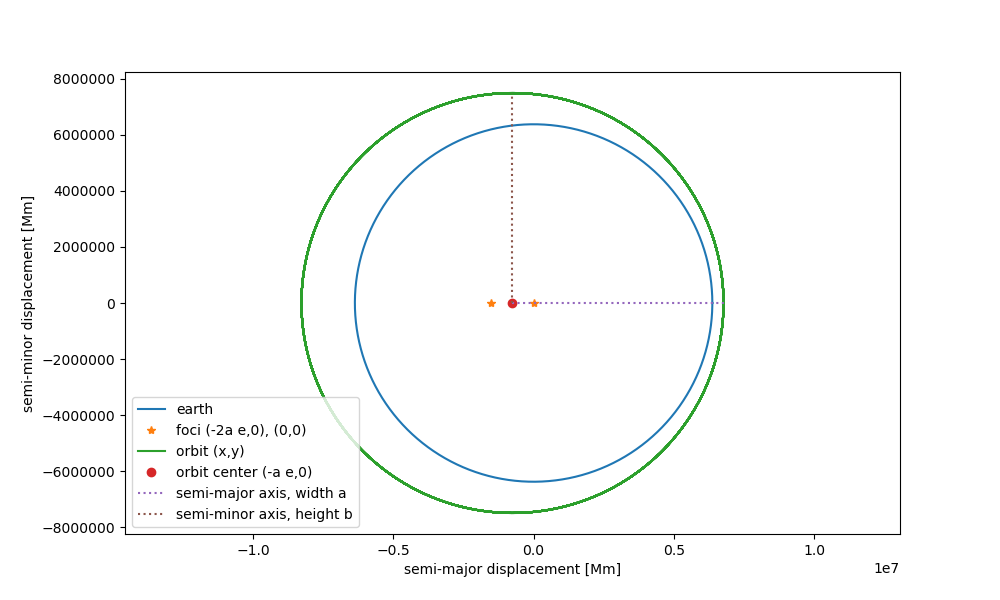

In [61]:
%matplotlib notebook
X = circlexy(R,np.linspace(0, 2*np.pi, N)) # curve of earth section by orbital plane 
t = np.linspace(0, orbits*P, 4*N)              # time list
E = t2E(e, H*t/a/b)                            # eq. 25, eccentric anomaly list, radians
x = a*(np.cos(E) - e)                          # eq. 20, x-coordinate list
y = b*np.sin(E)                                # eq. 21, y-coordinate list

f = plt.figure(figsize=(10,6))
ax = [f.add_subplot(1,1,1)]

ax[0].plot(X[0], X[1], label='earth')
ax[0].plot([0, -2*a*e], [0, 0], '*', label='foci (-2a e,0), (0,0)')
ax[0].plot(x, y, label='orbit (x,y)')
ax[0].plot(-a*e, 0, 'o', label='orbit center (-a e,0)')
ax[0].plot(np.array([-e, 1 - e])*a, np.array([0, 0]), ':', label='semi-major axis, width a')
ax[0].plot(-np.array([1, 1])*a*e, np.array([0, 1])*b, ':', label='semi-minor axis, height b')
ax[0].set_xlabel('semi-major displacement [Mm]')
ax[0].set_ylabel('semi-minor displacement [Mm]')
ax[0].axis('equal')
ax[0].legend(loc='lower left')

**This next cell creates an array of time values at which the positions of the satellite will be computed.** 

> E is an array of eccentric anomalies, where each component is a function of the eccentricity and time.

> x and y are the cartesian coordinates of the satellite in the orbital plane.

For the number of satellites being simulated, a call to the function xy2q is done which transforms the orbital-plane to a 3-dimensional coordinate-system. Each call generates x,y,z coordinates as the orbit evolves in time, q is an array the size of the number of satellites being simulated.

In [62]:
t = np.linspace(0, orbits*P, 4*N)     # time list, s
E = t2E(e, H*t/a/b)                   # eq. 25, eccentric anomaly list, radians
x = a*(np.cos(E) - e)                 # eq. 20, x-coordinate list
y = b*np.sin(E)                       # eq. 21, y-coordinate list
q = [0]*satellites                    # empty array of size number of satellites

Ω = np.pi/4
ω = np.linspace(0,2*np.pi-.1,satellites)

for i in range(0,satellites):         # get x,y,z - coords. for each satellite desired
    q[i] = xy2q(t, x, y, inclination, ω[i], Ω)

**Plotting the orbit(s) around a fixed *invisible* Earth.**

<IPython.core.display.Javascript object>


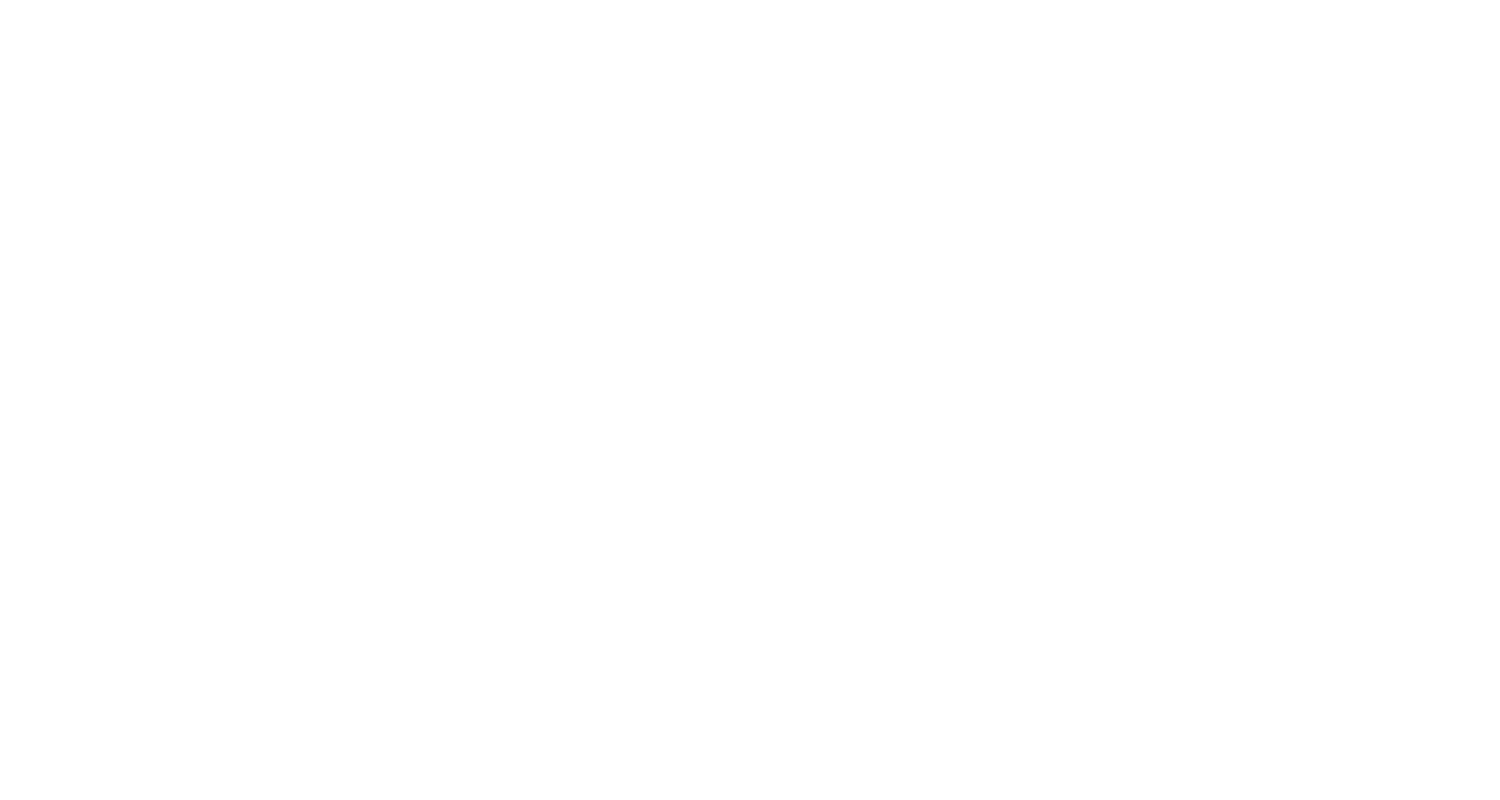

In [63]:
%matplotlib notebook
f = plt.figure(figsize=(15,8))
ax = f.add_subplot(1,2,1,projection='3d')
for i in range(0,satellites):
    title = "sat" + str(i+1) + "-orbit"
    ax.plot(q[i][:,0], q[i][:,1], q[i][:,2], label=title)
ax.set_xlabel('q₁')
ax.set_ylabel('q₂')
ax.set_zlabel('q₃')
ax.legend()

**Converting the 3-coordinate system for groundtracking**

$\psi = \tan^{-1} \big( \frac{q_x}{q_y} \big)$ is the logintudinal coordinate for ground tracking.

$\phi = \sin^{-1} \big( \frac{q_z}{|q|} \big)$ is the latitudinal coordinate for ground tracking.

In [64]:
# convert for ground-tracking
psi = [0]*satellites
phi = [0]*satellites

for i in range(0,satellites):
    psi[i] = np.arctan2(q[i][:,0], q[i][:,1])   # x-coordinate for groundtracking
    qq = np.zeros(np.size(q[i][:,2]))
    for j in range(0,np.size(q[i][:,2])):
        qq[j] = q[i][j,2] / np.sqrt( q[i][j,0]**2 + q[i][j,1]**2 + q[i][j,2]**2 )
    phi[i] = np.arcsin( qq )                    # y-coordinate for groundtracking

<IPython.core.display.Javascript object>


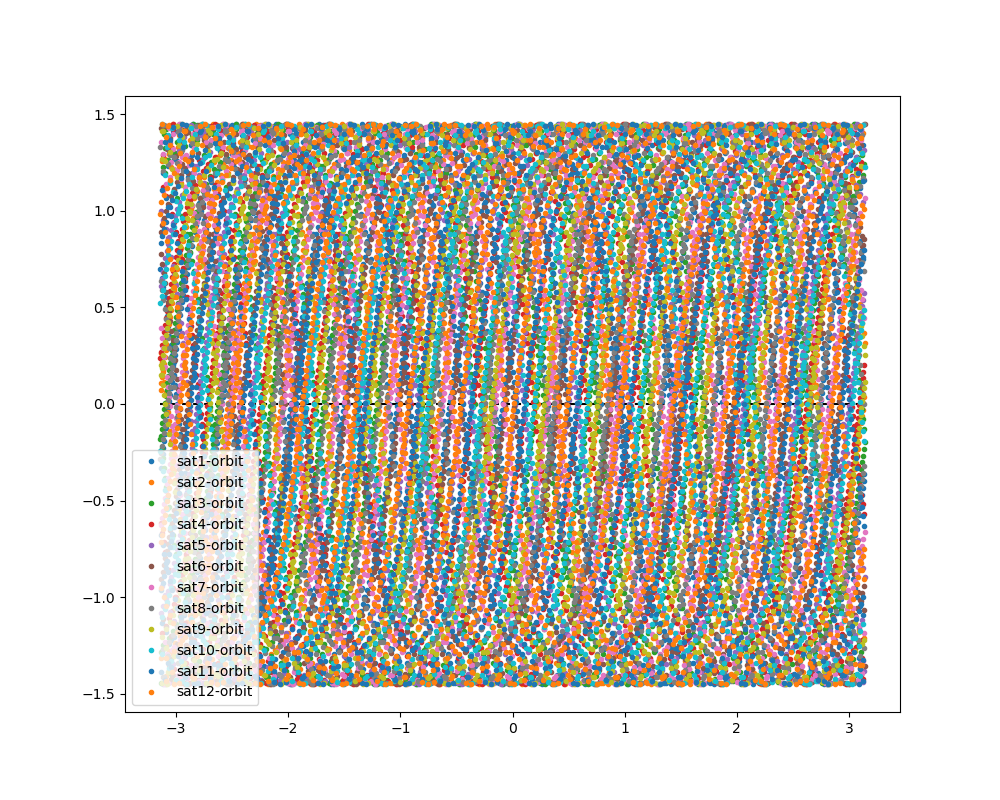

In [65]:
%matplotlib notebook
f = plt.figure(figsize=(10,8))
ax = f.add_subplot(1,1,1)
ax.plot([-np.pi,np.pi],[0,0],'--',c='k')       # equitorial line
for i in range(0,satellites):
    title = "sat" + str(i+1) + "-orbit"
    ax.plot(psi[i], phi[i],'.', label=title )
ax.legend()

In [66]:
# Finding when the satellite crosses the equator
#   and accumulating the points to form the line

# Setting up parameters needed to find area of
#               swath that crosses the equator
x1 = []
y1 = []
x2 = []
y2 = []

for i in range(0,satellites):
    for j in range(0,np.size(phi[i])-1):
        if( phi[i][j] > 0 and phi[i][j+1] < 0 ):
            x1.append( psi[i][j] )            # x1
            x2.append( psi[i][j+1] )          # x2
            y1.append( phi[i][j] )            # y1
            y2.append( phi[i][j+1] )          # y2
        else:
            if( phi[i][j] < 0 and phi[i][j+1] > 0 ):
                x1.append( psi[i][j] )            # x1
                x2.append( psi[i][j+1] )          # x2
                y1.append( phi[i][j] )            # y1
                y2.append( phi[i][j+1] )          # y2

In [67]:
# Calculating slope of the line crossing the equator.

n = np.size(x1)
slope = []
for i in range(0,n):
    m1 = y1[i] - y2[i]
    m2 = x1[i] - x2[i]
    m  = ( m1 / m2 )
    slope.append( m )  

In [48]:
# Centering a point at the equitorial line (a1,b1) each time we cross the equator

# Setting up parameters in order to center a point on an interpolated line at the equator
#       and to calculate the length of the swath crossing the equator, given our angle of  
#                                                                             inclination
u1 = []
v1 = []
a1 = []
b1 = []

for i in range(0,n):
    u1.append( x2[i] - x1[i] )
    v1.append( y2[i] - y1[i] )        

for i in range(0,n):
    a1.append( x1[i] - (u1[i]/v1[i])*y1[i] )
    b1.append( 0 )    

<IPython.core.display.Javascript object>


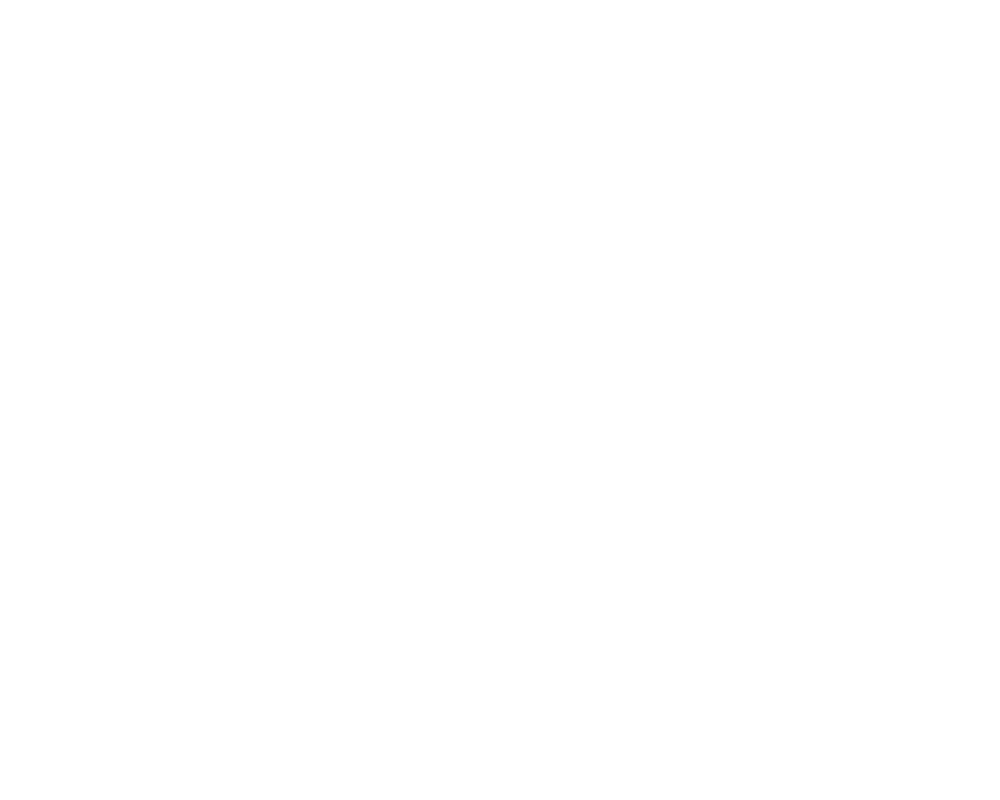

In [68]:
# Plotting the fixed point of where the satellite crosses the equator

f = plt.figure(figsize=(10,8))
ax = f.add_subplot(1,1,1)

ax.plot([-np.pi,np.pi],[0,0],'--',c='k')
ax.scatter(a1,b1, c='m')
for i in range(0,satellites):
    title = "sat" + str(i+1) + "-orbit"
    ax.plot(psi[i], phi[i],'.', label=title )
ax.legend()

<IPython.core.display.Javascript object>


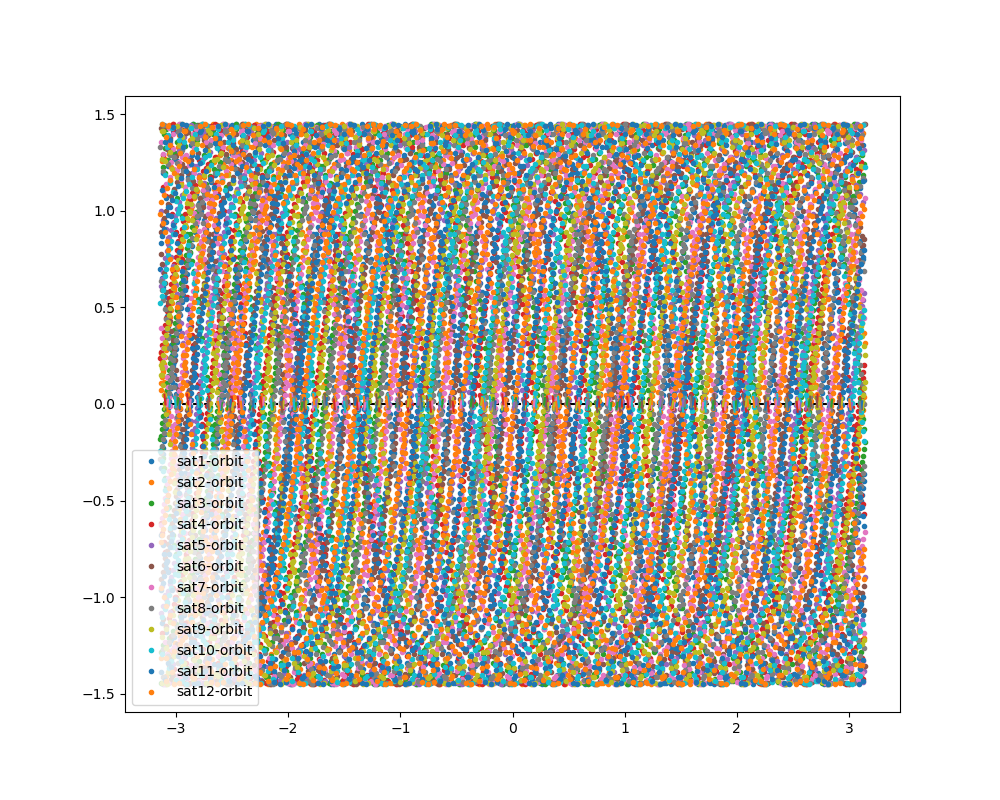

In [69]:
# Plotting the interpolated line for each crossing of the equator
%matplotlib notebook

f = plt.figure(figsize=(10,8))
ax = f.add_subplot(1,1,1)

plt.plot([-np.pi,np.pi],[0,0],'--',c='k')
for i in range(0,satellites):
    title = "sat" + str(i+1) + "-orbit"
    ax.plot(psi[i], phi[i],'.', label=title )
for i in range(0,np.size(x1)):
    ax.plot([x1[i], x2[i]],[y1[i], y2[i]])
ax.legend()

In [70]:
# Calculation of the swath length given our angle

swath_length = []
for i in range(0,np.size(slope)):
    swath_length.append( s * np.cos( np.arctan( slope[i] ) ) )

    
for i in range(0,np.size(swath_length)):
    swath_length[i] = swath_length[i] * (1/111320) * (1/57.3)
print(s,'\n')    
print(swath_length)

107179.67697244907 

[0.003524395197186966, 0.0030422464159909485, 0.003524135202299962, 0.003041920125384342, 0.003524143034946515, 0.0030422869213311246, 0.0035244186633764368, 0.0030431874184948735, 0.0035243725201006366, 0.0030422083975189676, 0.003524128320414877, 0.003041922463945071, 0.00352415173877766, 0.0030423297647893545, 0.0035244430526199535, 0.003043111193651354, 0.0035243510013683458, 0.0030421725360904994, 0.0035241223013950645, 0.00304192722217555, 0.0035241614061444393, 0.003042374973821456, 0.0035244683910197333, 0.0030430373277239887, 0.0035243303046577647, 0.003042138951577376, 0.003524395197186966, 0.0030422464159909042, 0.003524135202300166, 0.0030419201253842204, 0.0035241430349463106, 0.003042286921331161, 0.003524418663376535, 0.0030431874184948735, 0.003524372520100739, 0.0030422083975189676, 0.0035241283204148267, 0.003041922463945071, 0.0035241517387776342, 0.0030423297647893545, 0.0035244430526196976, 0.0030431111936514935, 0.0035243510013682946, 0.003042

In [51]:
# Capturing the interval for each pass accross the equator
# Setting up parameters to track the coverage as we pass the equator
equator_catch_plus  = []
equator_catch_minus = []

for i in range(0,n):
    equator_catch_plus.append( a1[i] + swath_length[i] )
    equator_catch_minus.append( a1[i] - swath_length[i] )

plt.plot([-np.pi,np.pi],[0,0])
plt.scatter(equator_catch_plus,b1,c='k')
plt.scatter(equator_catch_minus,b1,c='r')
for i in range(0,satellites):
    plt.plot(psi[i], phi[i])
    
plt.show()

In [72]:
# Comparing each interval we've crossed through periods and combining 
#     overlapping intervals. As well as offsetting the interval we've 
#         caught so instead of looking at [-pi,pi] we look at [0,2pi]
#       this should be easier to convert to a scale needed to compare
#                           with the equitorial coverage of the Earth

interval_caught1    = []
interval_caught2    = []
m = np.size(equator_catch_plus)

# First pass over the (maybe sunny side) equator
for i in range(0,m,2):
    if(equator_catch_plus[i] <= equator_catch_minus[i]):
        interval_caught1.append( [ np.pi + equator_catch_plus[i], np.pi + equator_catch_minus[i] ] )
    else:
        interval_caught1.append( [ np.pi + equator_catch_minus[i], np.pi + equator_catch_plus[i] ] )
    
# Second pass over the (maybe night side) equator
for i in range(1,m,2):
    if(equator_catch_plus[i] <= equator_catch_minus[i]):
        interval_caught2.append( [ np.pi + equator_catch_plus[i], np.pi + equator_catch_minus[i] ] )
    else:
        interval_caught2.append( [ np.pi + equator_catch_minus[i], np.pi + equator_catch_plus[i] ] )
    
print(np.size(interval_caught1,0),interval_caught1,'\n')
print(np.size(interval_caught2,0),interval_caught2)
print('\n')

m1 = np.size(interval_caught1,0)
m2 = np.size(interval_caught2,0)
area_passed_over_eq1 = interval_caught1[0]
area_passed_over_eq2 = interval_caught2[0]

for i in range(1,m1):
    area_passed_over_eq1 = interval( area_passed_over_eq1 ) | interval( interval_caught1[i] )

for i in range(1,m2):
    area_passed_over_eq2 = interval( area_passed_over_eq2 ) | interval( interval_caught2[i] )
    
print(np.size(area_passed_over_eq1,0),area_passed_over_eq1)
print('\n')
print(np.size(area_passed_over_eq2,0),area_passed_over_eq2)

13 [[0.5457381028204469, 0.5527861170101436], [0.07346606250941834, 0.08051408451623798], [5.884379270158714, 5.891427277018572], [5.412107223278933, 5.4191552534886505], [4.939835126209331, 4.9468831260248685], [4.4675630750722855, 4.474611114206691], [3.9952909909920575, 4.002338984426734], [3.5516771642056146, 3.557760331372895], [3.079404763048301, 3.0854885634190863], [2.60713302487391, 2.613216193255936], [2.1348606301833306, 2.14094439234177], [1.6625888864872898, 1.6686720573737355], [1.1903164953709844, 1.1964002206753563]] 

13 [[3.4516771642056145, 3.457760331372895], [2.9794047630483003, 2.985488563419086], [2.5071330248739105, 2.5132161932559365], [2.0348606301833305, 2.040944392341769], [1.56258888648729, 1.5686720573737354], [1.0903164953709847, 1.0964002206753563], [0.645738102820447, 0.6527861170101437], [0.17346606250941887, 0.18051408451623763], [5.984379270158714, 5.9914272770185715], [5.5121072232789325, 5.51915525348865], [5.039835126209333, 5.046883126024866], [4

In [73]:
# Post processing:
# We have a case where we go beyond the [0,2pi] range.
# This cell is fixing the left endpoint

# Setting tolerance in which we want to consider
#         the distance traveled beyond or domain
tol = -1e-10

# This checks the boolean of how negative the left end-point is
boo = tol in interval(area_passed_over_eq1[0])
if( boo == True ):
    print('1\n')
    print(area_passed_over_eq1)
    print('\n')
    area_passed_over_eq1 = coverage_correction_left(area_passed_over_eq1)
    print(area_passed_over_eq1)

print('\n')
boo = tol in interval(area_passed_over_eq2[0])
if( boo == True ):
    print('2\n')
    print(area_passed_over_eq2)
    print('\n')
    area_passed_over_eq2 = coverage_correction_left(area_passed_over_eq2)    
    print(area_passed_over_eq2)

In [74]:
# Now to fix the right endpoint if we go past 2*pi

# Post processing:
#    We have a case where we go beyond the [0,2pi] range.
tol = 1e-10

# This checks the boolean of how negative the left end-point is
boo = 2*np.pi + tol in interval(area_passed_over_eq1[-1])

if( boo == True ):
    print('1\n')
    print(area_passed_over_eq1)
    area_passed_over_eq1 = coverage_correction_right(area_passed_over_eq1)
    print('\n')
    print(area_passed_over_eq1)

print('\n')
boo = 2*np.pi + tol in interval(area_passed_over_eq2[-1])
if( boo == True ):
    print('1\n')
    print(area_passed_over_eq2)
    area_passed_over_eq2 = coverage_correction_right(area_passed_over_eq2)
    print('\n')
    print(area_passed_over_eq2)

In [75]:
# Now we convert this output in relation to the circumference of Earth -- 40,075 km
area_passed_over_eq1 = area_passed_over_eq1 * (R/1000) # convert to distance traveled in km
area_passed_over_eq2 = area_passed_over_eq2 * (R/1000) # convert to distance traveled in km
print('1 ',area_passed_over_eq1,'\n')
print('2 ',area_passed_over_eq2)

1  interval([468.0529307488543, 512.9559409768959], [3476.9022555643714, 3521.8052159894546], [7583.5168667937, 7622.276334244637], [10592.368426592722, 10631.124361842174], [13601.215861671542, 13639.975563920068], [16610.067444242297, 16648.82336353607], [19618.914844142637, 19657.674789842356], [22627.766467913014, 22666.52237946763], [25454.034062171115, 25498.936890365785], [28462.88366584059, 28507.786785188633], [31471.733059628757, 31516.635928475946], [34480.58274605364, 34525.48580854243], [37489.432112718736, 37534.33502644536]) 

2  interval([1105.1538107488575, 1150.0568209768937], [4114.003135564371, 4158.906095989455], [6946.415986793702, 6985.175454244637], [9955.267546592724, 9994.023481842174], [12964.114981671542, 13002.874683920063], [15972.9665642423, 16011.722483536072], [18981.81396414263, 19020.57390984236], [21990.665587913012, 22029.42149946763], [26091.134942171117, 26136.037770365776], [29099.984545840587, 29144.887665188628], [32108.833939628767, 32153.7368

<IPython.core.display.Javascript object>


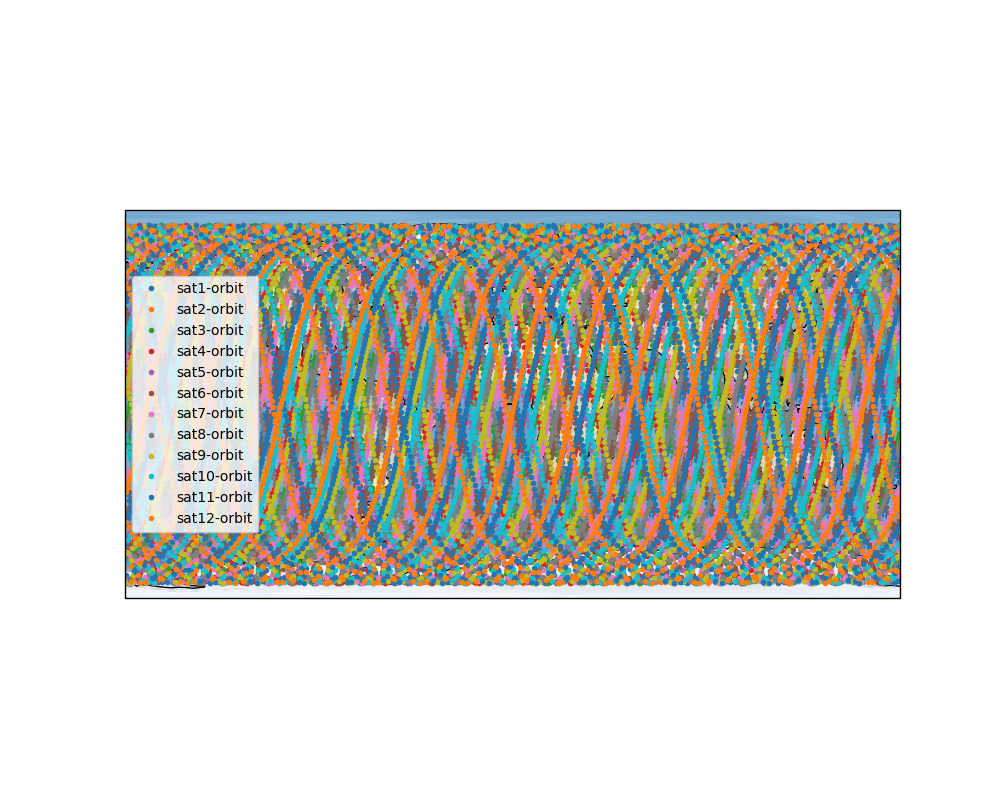

In [76]:
# Plotting the groundtracking of the satellite orbits
%matplotlib notebook

src_crs = ccrs.PlateCarree()
f = plt.figure(figsize=(10,8))
ax = f.add_subplot(1,1,1)
ax = plt.axes(projection=src_crs)
ax.stock_img()
ax.coastlines()
ax.plot([-np.pi,np.pi],[0,0],'--',c='k')       # equitorial line
for i in range(0,satellites):
    title = "sat" + str(i+1) + "-orbit"
    lon = psi[i] # [-pi,pi]
    lat = phi[i] # [-pi/2,pi/2]
    # converting to degrees
    lon = lon * (180/np.pi)
    lat = lat * (180/np.pi)
    ax.plot(lon,lat,'.', label=title)
ax.legend()